In [12]:
import numpy as np
from scipy.interpolate import interp1d

In [13]:
def trans_back(x, y, trans):
    '''
    inverse transfromation
    '''
    x = (x/trans[0][1])+trans[0][0]
    y = (y/trans[0][1])+trans[1][0]
    return x,y

In [14]:
def InitBeads(Guess, f, nBeads):
    nGuess = len(Guess)
    ds = np.linspace(0, 1, nGuess)
    ds[0] = 0

    for i in range(1, nGuess):
        ds[i] = ((Guess[i][0]-Guess[i-1][0])**2+(Guess[i][1]-Guess[i-1][1])**2)**0.5  # distance between tow points
    Sum = 0
    ds_cum = list(range(nGuess))
    for i in range(nGuess):
        Sum += ds[i]
        ds_cum[i] = Sum
    
    DS = list(range(nGuess))
    for i in range(len(ds_cum)):
        DS[i] = ds_cum[i] / Sum

    h = list(range(nBeads))
    for i in range(nBeads):
        h[i] = h[i] / float(nBeads-1)
    
    x = list(range(nGuess))
    y = list(range(nGuess))
    for i in range(nGuess):
        x[i] = Guess[i][0]
        y[i] = Guess[i][1]
    
    interX = interp1d(DS, x, kind='slinear')
    interY = interp1d(DS, y, kind='slinear')

    S_new = list(range(nBeads))

    X_new = interX(h)
    Y_new = interY(h)
    Z_new = f(X_new, Y_new)
    S_new = np.column_stack((X_new, Y_new))
    return np.column_stack((S_new, Z_new))

In [15]:
def grad(beads, f):
    dx = 0.01
    dy = 0.01
    grad_x = (f(beads[:, 0]-dx, beads[:, 1])-beads[:, 2])/dx
    grad_y = (f(beads[:, 0], beads[:,1]-dy)-beads[:, 2])/dy
    return np.column_stack((grad_x, grad_y))

In [16]:
def tangent(beads):
    tangent_x = np.gradient(beads[:, 0])
    tangent_y = np.gradient(beads[:, 1])
    # tangent_x[0],tangent_x[-1] = 0, 0
    # tangent_y[0],tangent_y[-1] = 0, 0
    return np.column_stack((tangent_x, tangent_y))

In [17]:
def grad_tangent(beads, f):
    gradxy = grad(beads, f)
    tangentxy = tangent(beads)
    projection = (gradxy * tangentxy).sum(axis=1) / np.linalg.norm(tangentxy, axis=1)
    projection = projection.reshape(-1,1)
    grad_tangentxy =  gradxy - projection * tangentxy
    grad_tangentxy[0,:] = np.array([0, 0])
    grad_tangentxy[-1,:] = np.array([0, 0])
    return grad_tangentxy

In [18]:
def walkdown(beads, step, f):
    nbeads = len(beads)
    # gradientX, gradientY = grad(beads, f)
    grad_tangentxy = grad_tangent(beads, f)
    beads[:, 0] = beads[:, 0] + grad_tangentxy[:,0]*step
    beads[:, 1] = beads[:, 1] + grad_tangentxy[:,1]*step

    beads[:, 2] = f(beads[:, 0], beads[:, 1])
    return beads

In [19]:
def redist(beads, f):
    nbeads = len(beads)
    ds = np.linspace(0, 1, nbeads)
    ds[0] = 0

    for i in range(1, nbeads):
        ds[i] = ((beads[i][0]-beads[i-1][0])**2+(beads[i][1]-beads[i-1][1])**2)**0.5  # distance between tow points
    Sum = 0
    ds_cum = list(range(nbeads))
    for i in range(nbeads):
        Sum += ds[i]
        ds_cum[i] = Sum
    
    DS = list(range(nbeads))
    for i in range(len(ds_cum)):
        DS[i] = ds_cum[i] / Sum

    h = list(range(nbeads))
    for i in range(nbeads):
        h[i] = h[i] / float(nbeads-1)
    
    x = list(range(nbeads))
    y = list(range(nbeads))
    for i in range(nbeads):
        x[i] = beads[i][0]
        y[i] = beads[i][1]
    
    interX = interp1d(DS, x, kind='cubic')
    interY = interp1d(DS, y, kind='cubic')

    S_new = list(range(nbeads))

    X_new = interX(h)
    Y_new = interY(h)
    Z_new = f(X_new, Y_new)
    S_new = np.column_stack((X_new, Y_new))
    return np.column_stack((S_new, Z_new))

In [20]:
def calcDiff(beads, beads2):
    nbeads = len(beads)
    Sum = np.sum((beads[:, 0]-beads2[:, 0])**2+(beads[:, 1]-beads2[:, 1])**2) / nbeads
    diff = np.sqrt(Sum)
    return diff

In [21]:
def f(x, y):
    return (1-x**2-y**2)**2+y**2/(x**2+y**2)

In [22]:
import matplotlib.pyplot as plt
from IPython import display
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg') # svg是矢量图格式

def set_figsize(figsize=(5, 4)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize # 图片的尺寸为3.5，2.5
 
set_figsize()

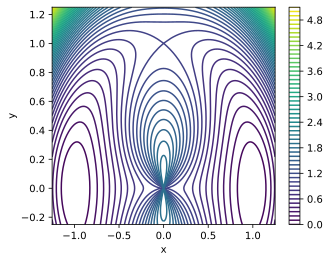

In [23]:
import matplotlib.pyplot as plt
n = 500
x = np.linspace(-1.25, 1.25, n)
y = np.linspace(-0.25, 1.25, n)
X, Y = np.meshgrid(x, y)
# plt.contourf(X, Y, f(X, Y),  levels = np.linspace(0, 5, 3))
plt.contour(X, Y, f(X, Y),  50)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

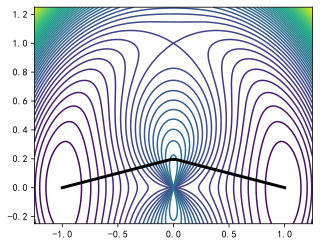

In [46]:
Guess = np.array([[-1, 0],[0,0.2],[1, 0]])
beads_init = InitBeads(Guess, f, nBeads=50)
plt.contour(X, Y, f(X, Y),  50)
plt.plot(beads_init[:, 0], beads_init[:, 1],lw=3, c='k')
# plt.contour(beads_init[:, 0], beads_init[:, 1], beads_init[:, 2])

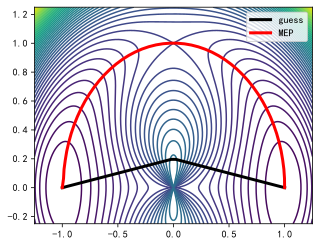

In [47]:
beads_new = np.copy(beads_init)
for _ in range(100):
    beads_new = walkdown(beads_new, 0.01, f)
    beads_new = redist(beads_new, f)
plt.contour(X, Y, f(X, Y),  50)
plt.plot(beads_init[:, 0], beads_init[:, 1],lw=3, c='k',label='guess')
plt.plot(beads_new[:, 0], beads_new[:, 1],lw=3, c='r',label='MEP')
plt.legend()
plt.show()
# plt.text(x=1.0, y=1.2, s= 'converged!')

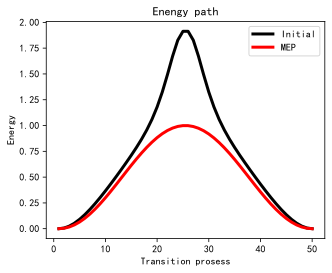

In [48]:
set_figsize((5,4))
plt.plot(range(1, 51), beads_init[:,2],lw=3,color='k',label='Initial')
# plt.title('Enengy path')
# plt.xlabel('Transition prosess')
# plt.ylabel('Energy')
plt.plot(range(1, 51), beads_new[:,2],lw=3,color='r',label='MEP')
plt.title('Enengy path')
plt.xlabel('Transition prosess')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [27]:
# beads_new

## NN 例子

In [28]:
x = np.linspace(-1,1, 100)
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
def nn_func(a, w, x):
    return a*np.tanh(w*x)
y = nn_func(8.3, -7.2, x) + np.random.normal(loc=0,scale=0.5,size=100)
# y
# print(y)

In [29]:
def loss_func(a, w):
    n = len(x)
    s = 0
    for i in range(n):
        s += (nn_func(a, w, x[i])-y[i])**2
    return s 

In [30]:
loss_func(0, 0)
loss_func(-0.1,0.1)

5893.208347547963

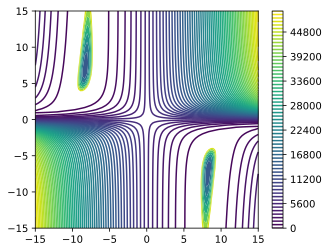

In [31]:
n = 100
a = np.linspace(-15, 15, n)
w = np.linspace(-15, 15, n)
A, W = np.meshgrid(a, w)
plt.contourf(A, W, loss_func(A, W), levels=np.linspace(0,100,10))
plt.contour(A, W, loss_func(A, W), 70)
plt.colorbar()
plt.show()

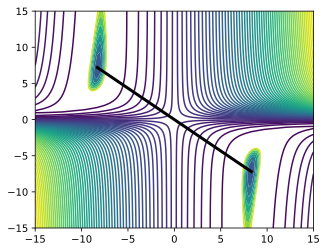

In [38]:
Guess = np.array([[-8.3, 7.2], [8.3, -7.2]])
beads_init = InitBeads(Guess, loss_func, nBeads=50)
plt.contourf(A, W, loss_func(A, W), levels=np.linspace(0,100,10))
plt.contour(A, W, loss_func(A, W), 70)
plt.plot(beads_init[:, 0], beads_init[:, 1],lw=3, c='k')
# plt.contour(beads_init[:, 0], beads_init[:, 1], beads_init[:, 2])

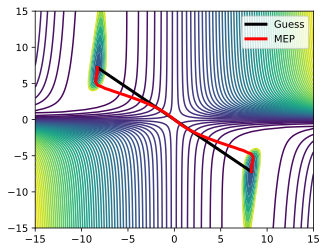

In [39]:
beads_new = np.copy(beads_init)
for _ in range(100):
    beads_new = walkdown(beads_new, 0.001, loss_func)
    beads_new = redist(beads_new, loss_func)
plt.contourf(A, W, loss_func(A, W), levels=np.linspace(0,100,10))
plt.contour(A, W, loss_func(A, W), 70)
plt.plot(beads_init[:, 0], beads_init[:, 1],lw=3, c='k', label='Guess')
plt.plot(beads_new[:, 0], beads_new[:, 1],lw=3, c='r',label='MEP')
plt.legend()
plt.show()
# plt.text(x=1.0, y=1.2, s= 'converged!')

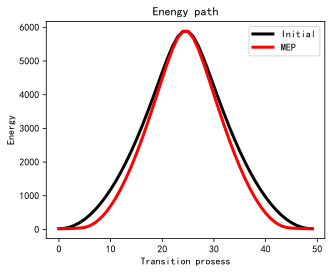

In [45]:
# beads_new
# plt.rc('font',family='SimHei')  #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
set_figsize((5,4))
plt.plot(beads_init[:,2], color='k',lw=3, label='Initial')
plt.plot(beads_new[:,2], color='r',lw=3,label='MEP')
plt.legend()
plt.title('Enengy path')
plt.xlabel('Transition prosess')
plt.ylabel('Energy')
plt.show()

In [35]:
aa = A.reshape(-1, 1)
ww = W.reshape(-1, 1)
ff = loss_func(A, W).reshape(-1,1)

In [36]:
np.savetxt('nn.txt', np.column_stack((aa, ww, ff)))